In [1]:
import pandas as pd
import numpy as np
import math
import os
from datetime import datetime
from os.path import join as pj
from copy import deepcopy
import matplotlib.pyplot as plt
import torch

month_map = dict(zip(['January', 'February', 'March', 'April', 'May', 'June',
     'July', 'August', 'September', 'October', 'November', 'December'],
     list(range(1,13))))
parse_date = lambda x: datetime.strptime(x , '%Y-%m-%d')
future_cols =['adr', 'is_canceled', 'reservation_status_date', 'reservation_status']
arrival_date_cols =['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month'] 


root = 'dataset'
train_x_path = pj(root ,'train.csv')
train_y_path = pj(root , 'train_label.csv')
test_x_path = pj(root , 'test.csv')
test_y_path = pj(root,  'test_nolabel.csv')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Feature selection

Parts:
- Main table (with all guessed future columns)
- **Target**: is_cancel 
- **Target**: adr

In [ ]:
### train

In [2]:
def preprocessing(df, drop_future = False, Test=False):
    df = df.replace({'arrival_date_month' : month_map})
    df['arrival_date'] = df[arrival_date_cols].astype(str).agg('-'.join, axis=1)
    df['arrival_date'] = df['arrival_date'].apply(parse_date)
    df = df.drop(arrival_date_cols, axis = 1)
    
    if not Test:
        df['reservation_status_date']=df['reservation_status_date'].apply(parse_date)
        
    if drop_future:
        for future in future_cols:
            if future in df.columns:
                df = df.drop([future] ,axis=1)
    return df

def get_feature(df , adr = False ):
    
    key = ['arrival_date']
    feat_level=[
        'hotel', 
        'meal',
        'country',
        'market_segment',
        'distribution_channel',
        'reserved_room_type',
        'assigned_room_type',
        'deposit_type',
        'customer_type']

    feat_num=['lead_time',
        'stays_in_weekend_nights',
        'stays_in_week_nights',
        'adults',
        'children',
        'babies', 
        'is_repeated_guest',
        'previous_cancellations',
        'previous_bookings_not_canceled',
        'booking_changes',
        'agent',
        'company', 
        'days_in_waiting_list',
        'required_car_parking_spaces',
        'total_of_special_requests']
    
    df[['children', 'agent' , 'company']] = df[['children', 'agent' , 'company']].fillna(0.0)
    df_proce = pd.get_dummies(df[feat_num + feat_level])
    df_proce = pd.concat([df[key], df_proce] ,axis=1)

    if adr:
        return df_proce , df['adr']
    return df_proce

def agg_by_date(df):
    df = df.groupby(['arrival_date']).sum()
    return df 

def data_augmentor(df, y, times = 10, sigma=0.1):
    df_g = deepcopy(df)
    y_g = deepcopy(y)
    print('original shape: ', df_g.shape)
    for _ in range(times):
        df_noise = np.random.normal(0,sigma, df.shape)
        df_g = pd.concat([df_g , df.add(df_noise, axis =1)], axis =0)
        y_g = pd.concat([y_g , deepcopy(y)], axis =0)
    print('augmented shape:' , df_g.shape)
    return df_g , y_g
# def agg(df , method='sum'):
#     if method=='sum':
#         df.groupby(['arrival_date']).sum()
#     elif method=='mean':
        

In [3]:
df_x = pd.read_csv(train_x_path)
df_y = pd.read_csv(train_y_path)

df_x_t = pd.read_csv(test_x_path)
df_y_t = pd.read_csv(test_y_path)
df_x = preprocessing(df_x)
df_y['arrival_date'] = df_y['arrival_date'].apply(parse_date)


df_x_t = preprocessing(df_x_t, Test = True)
df_y_t['arrival_date'] = df_y_t['arrival_date'].apply(parse_date)

## Sum( adr ) by date

- **valid**: no neg. date
- **invalid**: with neg. date

In [56]:
invalid_x , valid_x = deepcopy(df_x),deepcopy(df_x)
valid_x = valid_x.loc[valid_x['is_canceled']==0,:].reset_index(drop=True)
valid_x['adr'] = abs(valid_x['adr'])

In [57]:
v_adr = valid_x.groupby('arrival_date').sum()[['adr']]
inv_adr = invalid_x.groupby('arrival_date').sum()[['adr']]

# v_adr = valid_x.groupby('arrival_date').mean()[['adr']]
# inv_adr = invalid_x.groupby('arrival_date').mean()[['adr']]


<AxesSubplot:>

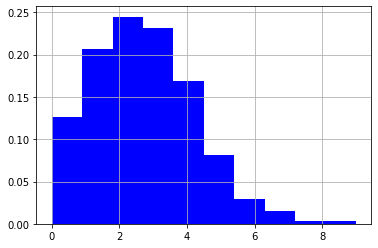

In [58]:
v_normal = v_adr['adr']
v_normal = 9*(v_normal - v_normal.min())/\
            (v_normal.max() - v_normal.min())
v_normal.hist(density= True,bins=10,cumulative=0,color='b')


<AxesSubplot:>

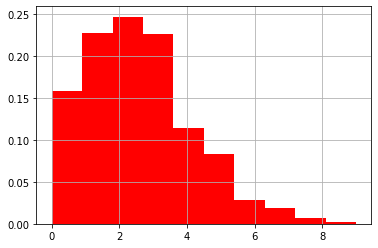

In [59]:
inv_normal = inv_adr['adr']
inv_normal = 9*(inv_normal - inv_normal.min())/\
            (inv_normal.max() - inv_normal.min())

inv_normal.hist(density= True,bins=10,cumulative=0,color='r')

## Sum( adr $\times$ date_range) by date

- **valid**: no neg. date
- **invalid**: with neg. date

In [60]:
invalid_x , valid_x = deepcopy(df_x),deepcopy(df_x)
valid_x = valid_x.loc[valid_x['is_canceled']==0,:].reset_index(drop=True)
valid_x['adr'] = abs(valid_x['adr'])

date_range = (df_x['reservation_status_date']-df_x['arrival_date'])\
            .apply(lambda x : x.days)

valid_x['date_range']=date_range
valid_x['date_range']=valid_x['date_range'].apply(lambda x: 0 if x<0 else x)
valid_x['sum_adr'] = valid_x['date_range']*valid_x['adr']

invalid_x['date_range']=date_range
invalid_x['sum_adr'] = invalid_x['date_range']*invalid_x['adr']

In [61]:
v_sumadr = valid_x.groupby('arrival_date').sum()[['sum_adr']]
inv_sumadr = invalid_x.groupby('arrival_date').sum()[['sum_adr']]
# v_adr = valid_x.groupby('arrival_date').mean()[['adr']]
# inv_adr = invalid_x.groupby('arrival_date').mean()[['adr']]


<AxesSubplot:>

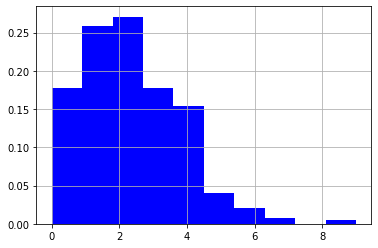

In [70]:
vsum_normal = v_sumadr['sum_adr']
vsum_normal = 9*(vsum_normal - vsum_normal.min())/\
            (vsum_normal.max() - vsum_normal.min())
vsum_normal.hist(density= True,bins=10,cumulative=0,color='b')


<AxesSubplot:>

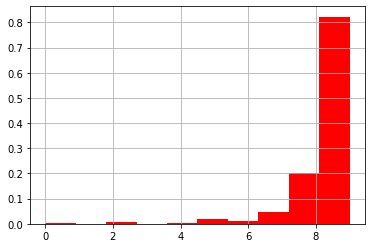

In [71]:
invsum_normal = inv_sumadr['sum_adr']
invsum_normal = 9*(invsum_normal - invsum_normal.min())/\
            (invsum_normal.max() - invsum_normal.min())

invsum_normal.hist(density= True,bins=10,cumulative=0,color='r')

## True $x$ label distribuion

<AxesSubplot:>

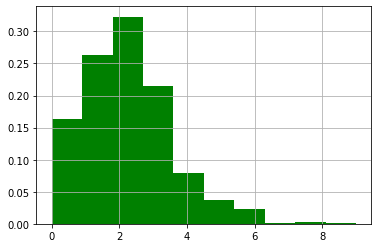

In [12]:
df_y['label'].hist(density=True , bins=10 ,cumulative=0 , color='g')

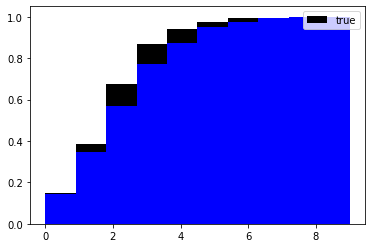

In [13]:
infer_label = vsum_normal.values
true_label = df_y['label']
plt.hist(true_label , 
        density=True,
         cumulative=1 ,
         bins=10,
         color='black',
        label='true')
plt.legend(loc='upper right')
plt.hist(infer_label ,
         density=True,
         cumulative=1 ,
         bins=10,
         color='blue',
        label='inferred')

plt.show()

In [14]:
abs(infer_label - true_label).sum()/len(infer_label)

0.7965563250884072

In [254]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score , f1_score , recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.preprocessing import StandardScaler as sc
from sklearn.multiclass import OneVsRestClassifier as OVR

## From normalized_adr to label

In [246]:
x, y = infer_label, true_label.values
x, y = x.reshape(-1 ,1) , y.reshape(-1,1)
test_size = 300 # from 640

### Linear Regression

In [303]:
model_lr = LinearRegression(normalize=False)
model_lr = OVR(model_lr)
model_lr.fit(x[:test_size,:] , y[:test_size,:])


OneVsRestClassifier(estimator=LinearRegression())

In [304]:
y_pred = model_lr.predict(x[test_size:,:])
mae(y[test_size:,:] , y_pred)

0.8647058823529412

### SVR

In [301]:
model_svr = SVC(C=10)
# model_svr = OVR(model_svr)
model_svr.fit(x[:test_size,:] , y[:test_size,:].flatten())


SVC(C=10)

In [302]:
y_pred = model_lr.predict(x[test_size:,:])
mae(y[test_size:,:].flatten() , y_pred)

0.8647058823529412

### LGB

In [307]:
from lightgbm import LGBMClassifier

model_lgb = LGBMClassifier(num_class =10 ,
                           objective='multiclass',
                           metric='multi_logloss')
model_lgb.fit(x[:test_size,:] , y[:test_size,:].flatten())

LGBMClassifier(metric='multi_logloss', num_class=10, objective='multiclass')

In [308]:
y_pred = model_lgb.predict(x[test_size:,:])
mae(y[test_size:,:].flatten() , y_pred)

0.08529411764705883

In [309]:
y_p = model_lgb.predict(x[:test_size,:])
mae(y[:test_size,:].flatten() , y_p)

0.02666666666666667

In [ ]:
import joblib
# from sklearn.model_selection import GridSearchCV 

# parameters ={
#     'max_leaf': [100 , 200, 300 ,400 , 600],
#     'max_depth': [2, 5 ,10 , 15, 20,  35],
#     'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
#     'feature_fraction': [0.6, 0.7, 0.8, 0.95],
#     'bagging_fraction': [0.6, 0.7, 0.8, 0.95],
#     'bagging_freq': [2, 4, 6, 8],
#     'lambda_l1': [0.1, 0.4, 0.6],
#     'lambda_l2': [10, 15, 35],
#     'cat_smooth': [1, 10, 15, 20, 35],
#     }
# gs = GridSearchCV(model_lgb , 
#                   param_grid =parameters , 
#                   n_jobs = 20)
# gs.fit(x[:test_size,:] , y[:test_size,:].flatten())
# gs.best_params_
gs_ = joblib.load("gs_model_yy")

In [295]:
import pickle 
with open('yy.pickle', 'wb') as f:
    pickle.dump([x[:test_size,:] , y[:test_size,:].flatten()] ,f)
    

In [296]:
with open('yy.pickle' ,'rb') as f:
    x_train , y_train  =  pickle.load(f)

## Remaining Feature

In [179]:
remain_cols=[\
            'lead_time',
            'stays_in_weekend_nights', 
            'stays_in_week_nights',
            'adults', 
            'children',
            'babies', 
#             'meal',
#             'country',
#             'market_segment',
#             'distribution_channel',
            'is_repeated_guest', 
            'previous_cancellations',
            'previous_bookings_not_canceled',
#             'reserved_room_type',
#             'assigned_room_type', 
            'booking_changes',
#             'deposit_type',
            'agent',
            'company',
            'days_in_waiting_list',
#             'customer_type',
            'required_car_parking_spaces', 
            'total_of_special_requests',
              ]


In [171]:
valid_x_sum = valid_x.groupby('arrival_date').sum()

In [176]:
valid_x_sum.columns

Index(['ID', 'is_canceled', 'lead_time', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'date_range', 'sum_adr'],
      dtype='object')

array([[<AxesSubplot:title={'center':'lead_time'}>,
        <AxesSubplot:title={'center':'stays_in_weekend_nights'}>],
       [<AxesSubplot:title={'center':'stays_in_week_nights'}>,
        <AxesSubplot:title={'center':'adults'}>]], dtype=object)

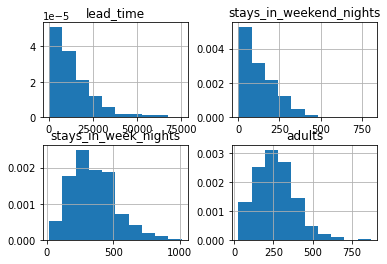

In [183]:
valid_x_sum[remain_cols[:4]].hist(bins=10,density=True)

array([[<AxesSubplot:title={'center':'children'}>,
        <AxesSubplot:title={'center':'babies'}>],
       [<AxesSubplot:title={'center':'is_repeated_guest'}>,
        <AxesSubplot:title={'center':'previous_cancellations'}>]],
      dtype=object)

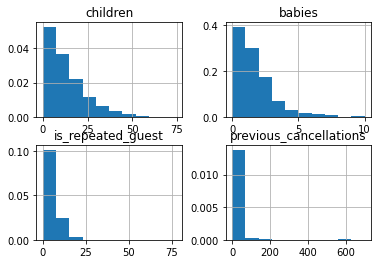

In [184]:
valid_x_sum[remain_cols[4:8]].hist(bins=10,density=True)

array([[<AxesSubplot:title={'center':'previous_bookings_not_canceled'}>,
        <AxesSubplot:title={'center':'booking_changes'}>],
       [<AxesSubplot:title={'center':'agent'}>,
        <AxesSubplot:title={'center':'company'}>]], dtype=object)

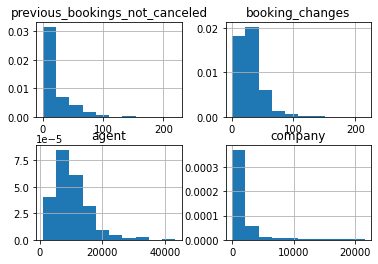

In [185]:
valid_x_sum[remain_cols[8:12]].hist(bins=10,density=True)

array([[<AxesSubplot:title={'center':'days_in_waiting_list'}>,
        <AxesSubplot:title={'center':'required_car_parking_spaces'}>],
       [<AxesSubplot:title={'center':'total_of_special_requests'}>,
        <AxesSubplot:>]], dtype=object)

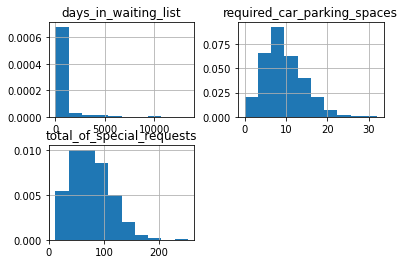

In [186]:
valid_x_sum[remain_cols[12:]].hist(bins=10,density=True)

In [187]:
remain_cols

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [191]:
def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v


valid_x_sum['lead_time'].corr(true_label, method='pearson')

nan

In [313]:
remain_x_y = deepcopy(valid_x_sum[remain_cols])
remain_x_y['label']=true_label.values
remain_x_y = remain_x_y[['label']+remain_cols]
# .corr(method='pearson')


In [314]:
((remain_x_y.corr(method='pearson')**2)**.5)\
            .sort_values('label',ascending=False)

,label,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
label,1.000000,0.513087,0.633663,0.556352,0.637922,0.624413,0.347326,0.181930,0.012054,0.120508,0.409913,0.432488,0.076464,0.097123,0.458513,0.626447
adults,0.637922,0.809737,0.524372,0.826537,1.000000,0.439049,0.185092,0.016638,0.116263,0.039203,0.549339,0.624377,0.155262,0.271310,0.480812,0.636411
stays_in_weekend_nights,0.633663,0.342950,1.000000,0.242447,0.524372,0.375137,0.275103,0.186849,0.048385,0.148287,0.259763,0.442653,0.111548,0.028835,0.272680,0.458020
total_of_special_requests,0.626447,0.464766,0.458020,0.537144,0.636411,0.600007,0.270889,0.030378,0.112144,0.029098,0.423111,0.490732,0.001201,0.068228,0.485960,1.000000
children,0.624413,0.274927,0.375137,0.348007,0.439049,1.000000,0.340986,0.153325,0.101387,0.104211,0.342271,0.338233,0.108282,0.013109,0.487390,0.600007
stays_in_week_nights,0.556352,0.752619,0.242447,1.000000,0.826537,0.348007,0.112213,0.084009,0.105784,0.102751,0.557976,0.564633,0.240636,0.287191,0.431735,0.537144
lead_time,0.513087,1.000000,0.342950,0.752619,0.809737,0.274927,0.094193,0.083254,0.128481,0.088290,0.507240,0.449613,0.146675,0.323660,0.307095,0.464766
required_car_parking_spaces,0.458513,0.307095,0.272680,0.431735,0.480812,0.487390,0.225466,0.006595,0.086548,0.066465,0.383784,0.401743,0.151457,0.094161,1.000000,0.485960
agent,0.432488,0.449613,0.442653,0.564633,0.624377,0.338233,0.151318,0.014482,0.017619,0.005433,0.385253,1.000000,0.010146,0.121016,0.401743,0.490732
booking_changes,0.409913,0.507240,0.259763,0.557976,0.549339,0.342271,0.130197,0.009156,0.056233,0.044632,1.000000,0.385253,0.331493,0.141522,0.383784,0.423111


In [315]:
((remain_x_y.corr(method='pearson')**1)**1)\
            .sort_values('label',ascending=False)

,label,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
label,1.000000,0.513087,0.633663,0.556352,0.637922,0.624413,0.347326,-0.181930,-0.012054,-0.120508,0.409913,0.432488,-0.076464,0.097123,0.458513,0.626447
adults,0.637922,0.809737,0.524372,0.826537,1.000000,0.439049,0.185092,-0.016638,0.116263,-0.039203,0.549339,0.624377,0.155262,0.271310,0.480812,0.636411
stays_in_weekend_nights,0.633663,0.342950,1.000000,0.242447,0.524372,0.375137,0.275103,-0.186849,0.048385,-0.148287,0.259763,0.442653,-0.111548,0.028835,0.272680,0.458020
total_of_special_requests,0.626447,0.464766,0.458020,0.537144,0.636411,0.600007,0.270889,-0.030378,-0.112144,0.029098,0.423111,0.490732,-0.001201,0.068228,0.485960,1.000000
children,0.624413,0.274927,0.375137,0.348007,0.439049,1.000000,0.340986,-0.153325,-0.101387,-0.104211,0.342271,0.338233,-0.108282,0.013109,0.487390,0.600007
stays_in_week_nights,0.556352,0.752619,0.242447,1.000000,0.826537,0.348007,0.112213,0.084009,0.105784,0.102751,0.557976,0.564633,0.240636,0.287191,0.431735,0.537144
lead_time,0.513087,1.000000,0.342950,0.752619,0.809737,0.274927,0.094193,-0.083254,0.128481,-0.088290,0.507240,0.449613,0.146675,0.323660,0.307095,0.464766
required_car_parking_spaces,0.458513,0.307095,0.272680,0.431735,0.480812,0.487390,0.225466,0.006595,-0.086548,0.066465,0.383784,0.401743,0.151457,0.094161,1.000000,0.485960
agent,0.432488,0.449613,0.442653,0.564633,0.624377,0.338233,0.151318,0.014482,0.017619,0.005433,0.385253,1.000000,0.010146,0.121016,0.401743,0.490732
booking_changes,0.409913,0.507240,0.259763,0.557976,0.549339,0.342271,0.130197,0.009156,-0.056233,0.044632,1.000000,0.385253,0.331493,0.141522,0.383784,0.423111


In [317]:
related_cols= [ 
        'adults',
        'stays_in_weekend_nights',
        'total_of_special_requests',
        'children',
        'stays_in_week_nights',
        'lead_time',
        'required_car_parking_spaces',
        'agent',
        'booking_changes',
        'babies'] 
related_x = remain_x_y[related_cols]

In [ ]:
x, y = 

model_lgb = LGBMClassifier(num_class =10 ,
                           objective='multiclass',
                           metric='multi_logloss')
model_lgb.fit(x[:test_size,:] , y[:test_size,:].flatten())